In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import numpy as np
from scipy import special
from copy import deepcopy

# Units : A * H / (m * cm), therefore need to multiply by 100x.
# Units are then T / A
#
# Amperes * H (what is H?) / (meters * centimeters)
# Then Tesla / Ampere

# H / m (what is H => ? / meter...)
MU_0 = 4 * np.pi * 1.0e-7

# rectangular in the X, Y plane @ z0 distance from the origin
# has side lengths 2*a1 and 2*b1

# QUESTION: what are r, d and c ???

In [36]:
def magnetic_field_components(position, center, radius):
    """
    Defines the   components of the  magnetic field created by   current flowing through a circular loop
    whose plane is orthogonal to Oz;
  
    position - an array of shape  (3, m, n, p). 
    it stores the 3d grid of points  at which the magnetic field is evaluated
    The coordinates of the points are x, y, z= position[0], position[1], position[2]
    
    center -  an array of shape (3, ), representing the center of the circular loop
    
    radius - float, loop radius
           
    Returns an array B, of shape (3, m, n, p), that stores in B[0], B[1], B[2], 
    the vector field  components  at the corresponding position(s)
    """
    
    for k in range(3):
        position[k]-=center[k]
    
    x, y, z=position
    #the cylindrical coordinates of position points are (rho, theta, z)
    rho = np.sqrt(x**2 + y**2)
    theta =  np.arctan2(y,x)
    
    #the magnetic firld components are calculated following Phys Rev A, vol 35, 4, pages 1535-1546
    E = special.ellipe((4 * radius * rho)/( (radius + rho)**2 + z**2))
    K = special.ellipk((4 * radius * rho)/( (radius + rho)**2 + z**2))
    B_z =  1/np.sqrt((radius + rho)**2 + z**2) * (K+ E * (radius**2 - rho**2 - z**2)/((radius - rho)**2 + z**2))
    B_rho = z/(rho*np.sqrt((radius + rho)**2 + z**2)) * (-K+ E * (radius**2 + rho**2 + z**2)/((radius - rho)**2 + z**2))
    
    B_rho[np.isinf(B_rho)] = 0
    B_rho[np.isnan(B_rho)] = 0
    B_z[np.isnan(B_z)]     = 0
    B_z[np.isinf(B_z)]     = 0
   
    return np.stack((np.cos(theta)*B_rho, np.sin(theta)*B_rho, B_z))

In [37]:
def get_loop_data(center, radius):
    theta = np.linspace(0, 2*np.pi, 36)[:, None]
    loop = center+radius * (np.cos(theta)*np.r_[1, 0, 0] + np.sin(theta)*np.r_[0,1,0]) #cicle C(center, radius) 
   
    return dict(type='scatter3d',
                x=loop[:,0],
                y=loop[:,1],
                z=loop[:,2],
                mode='lines',
                showlegend=False, 
                line=dict(width=15, color='rgb(120, 113, 86)')
                )

In [38]:
matter=[[0.0, 'rgb(253, 237, 176)'],#cmocean
        [0.1, 'rgb(250, 202, 143)'],
        [0.2, 'rgb(245, 166, 114)'],
        [0.3, 'rgb(238, 132, 93)'],
        [0.4, 'rgb(226, 97, 82)'],
        [0.5, 'rgb(206, 67, 86)'],
        [0.6, 'rgb(179, 46, 94)'],
        [0.7, 'rgb(147, 31, 99)'],
        [0.8, 'rgb(114, 25, 95)'],
        [0.9, 'rgb(79, 21, 82)'],
        [1.0, 'rgb(47, 15, 61)']]
# The vector field is defined at the  points of the following  grid:
points = np.mgrid[-0.2:0.2:20j, -0.2:0.2:20j, -0.2:0.2:20j]

# Set the radius and the  loop centers
center1 = np.r_[0, 0, 0.15]
center2 = np.r_[0, 0, 0]
radius  = 0.15

centers = np.vstack((center1,   center2,  -center1 )) 
radii  = np.r_[radius, radius, radius]

B = np.zeros(points.shape)

#The magnetic field, B,  is the sum of the magnetic fields genetared by each current in the three loops
for  center, radius in zip(centers, radii):
    B += magnetic_field_components(deepcopy(points), center, radius)#pass a deepcopy  because the initial points are
                                                                    #translated within the function body
vf_norm = np.sqrt(B[0]**2 + B[1]**2 + B[2]**2)


#if the range of the vector field norm is large, we restrict it to an interval [0, norm_max] to get a nice plot
#for this example it's not the case and we can set
norm_max = 133# this is here vf_norm.max()
for k in range(3):
    B[k][vf_norm > norm_max]=0   
x, y, z = points
u, v, w = B    

In [39]:
data=[]

for  center, radius in zip(centers, radii):
    data.append(get_loop_data(center, radius))

#the vector field as a cone trace
x, y, z, u, v, w = x.flatten(), y.flatten(), z.flatten(), u.flatten(), v.flatten(), w.flatten()

data.append(dict(type='cone',
                 x=x,
                 y=y, 
                 z=z,
                 u=u,
                 v=v, 
                 w=w,
                 anchor='tail',
                 colorscale=matter, 
                 colorbar=dict(thickness=20, ticklen=4),
                 sizemode='scaled',
                 sizeref=1,
                 opacity=0.8,
                 lighting=dict(ambient=0.35,
                               diffuse=1,
                               fresnel=4,         
                               specular=0.5,
                               roughness=0.5
                              ),
                 lightposition=dict(x=100,
                                    y=100,
                                    z=100)
                 ))
axis = dict(showbackground=True, 
            backgroundcolor="rgb(235, 235,235)",
            gridcolor="rgb(255, 255, 255)",      
            zerolinecolor="rgb(255, 255, 255)")

layout = dict(title='Magnetic field created by electric current through three circular loops', 
              width=900,
              height=800,
              autosize=False,
              scene=dict(camera=dict(eye=dict(x=1.2, y=1.2, z=0.65)),
                         xaxis=dict(axis),
                         yaxis=dict(axis), 
                         zaxis=dict(axis),
                         aspectratio=dict(x=1,
                                          y=1,
                                          z=1))
              )

In [40]:
fig=dict(data=data, layout=layout)

In [43]:
py.sign_in('aali7075', 'mCAbs3Rl4l9SJTjJ8eKj')
py.iplot(fig, filename='magneticfield3', validate=False)

PlotlyRequestError: This file is too big! Your current subscription is limited to 524.288 KB uploads. For more information, please visit: https://plotly.com/get-pricing/.

In [13]:
r1 = lambda x, y, z, a1, b1, z0: np.sqrt((a1 + x) ** 2 + (y + b1) ** 2 + (z - z0) ** 2)
r2 = lambda x, y, z, a1, b1, z0: np.sqrt((a1 - x) ** 2 + (y + b1) ** 2 + (z - z0) ** 2)
r3 = lambda x, y, z, a1, b1, z0: np.sqrt((a1 - x) ** 2 + (y - b1) ** 2 + (z - z0) ** 2)
r4 = lambda x, y, z, a1, b1, z0: np.sqrt((a1 + x) ** 2 + (y - b1) ** 2 + (z - z0) ** 2)

d1 = lambda x, y, z, a1, b1, z0: y + b1
d2 = lambda x, y, z, a1, b1, z0: y + b1
d3 = lambda x, y, z, a1, b1, z0: y - b1
d4 = lambda x, y, z, a1, b1, z0: y - b1

c1 = lambda x, y, z, a1, b1, z0: a1 + x
c2 = lambda x, y, z, a1, b1, z0: a1 - x
c3 = lambda x, y, z, a1, b1, z0: -a1 + x
c4 = lambda x, y, z, a1, b1, z0: -a1 - x

In [14]:
def _eval_r(x, y, z, a1, b1, z0):
    return r1(x, y, z, a1, b1, z0), r2(x, y, z, a1, b1, z0), r3(x, y, z, a1, b1, z0), r4(x, y, z, a1, b1, z0)


def _eval_d(x, y, z, a1, b1, z0):
    return d1(x, y, z, a1, b1, z0), d2(x, y, z, a1, b1, z0), d3(x, y, z, a1, b1, z0), d4(x, y, z, a1, b1, z0)


def _eval_c(x, y, z, a1, b1, z0):
    return c1(x, y, z, a1, b1, z0), c2(x, y, z, a1, b1, z0), c3(x, y, z, a1, b1, z0), c4(x, y, z, a1, b1, z0)


In [15]:
def Bz(x, y, z, a1, b1, z0, N):
    """
    Magnetic flux density in Z direction at point (x, y, z)

    :param x: x location
    :param y: y location
    :param z: z location
    :param a1: (half of) coil side length A
    :param b1: (half of) coil side length B
    :param z0: Distance of coil from origin
    :param N: Current (Milliamps?)

    :return: Magnetic flux density
    """

    # c = 100.0 * 1e6 * MU_0 * N / (4 * np.pi)
    #
    # # compute each sub-function once and store result
    # _r1, _r2, _r3, _r4 = _eval_r(x, y, z, a1, b1, z0)
    # _d1, _d2, _d3, _d4 = _eval_d(x, y, z, a1, b1, z0)
    # _c1, _c2, _c3, _c4 = _eval_c(x, y, z, a1, b1, z0)
    #
    # # return constant * inner sum of various function combinations
    # # tried to keep things clean, or at least cleaner than the original mathematica code
    # return c * np.sum([
    #     -1.0 *  _d1 / (_r1 * (_r1 + _c1)),
    #     -1.0 *  _c1 / (_r1 * (_r1 + _d1)),
    #             _d2 / (_r2 * (_r2 - _c2)),
    #     -1.0 *  _c2 / (_r2 * (_r2 + _d2)),
    #     -1.0 *  _d3 / (_r3 * (_r3 + _c3)),
    #     -1.0 *  _c3 / (_r3 * (_r3 + _d3)),
    #             _d4 / (_r4 * (_r4 - _c4)),
    #     -1.0 *  _c4 / (_r4 * (_r4 + _c4))
    # ], axis=0)

    _k = 100.0 * 1e6 * MU_0 * N / (4 * np.pi)

    # compute each sub-function once and store result
    _r = _eval_r(x, y, z, a1, b1, z0)
    _d = _eval_d(x, y, z, a1, b1, z0)
    _c = _eval_c(x, y, z, a1, b1, z0)

    # return constant * inner sum of various function combinations
    # tried to keep things clean, or at least cleaner than the original mathematica code

    return _k * np.sum([((-1**(i+1))*_d[i] / (_r[i] * (_r[i] + (-1**i)*_c[i]))) -
                        (_c[i] / (_r[i] * (_r[i] - _d[i]))) for i in range(4)], axis=0)


In [16]:
def Bx(x, y, z, a1, b1, z0, N):
    """
    Magnetic flux density in X direction at point (x, y, z)

    :param x: x location
    :param y: y location
    :param z: z location
    :param a1: (half of) coil side length A
    :param b1: (half of) coil side length B
    :param z0: Distance of coil from origin
    :param N: Current (Milliamps?)

    :return: Magnetic flux density
    """

    _k = 100.0 * MU_0 * N / (4 * np.pi)
    _z = z - z0
    _r = _eval_r(x, y, z, a1, b1, z0)
    _d = _eval_d(x, y, z, a1, b1, z0)

    return _k * np.sum([(-1**i) * _z / (_r[i] * (_r[i] + _d[i])) for i in range(4)], axis=0)

def By(x, y, z, a1, b1, z0, N):
    """
    Magnetic flux density in X direction at point (x, y, z)

    :param x: x location
    :param y: y location
    :param z: z location
    :param a1: (half of) coil side length A
    :param b1: (half of) coil side length B
    :param z0: Distance of coil from origin
    :param N: Current (Milliamps?)

    :return: Magnetic flux density
    """

    _k = 100.0 * MU_0 * N / (4 * np.pi)
    _z = z - z0

    _r = _eval_r(x, y, z, a1, b1, z0)
    _c = _eval_c(x, y, z, a1, b1, z0)

    return _k * np.sum([(-1**i) * _z / (_r[i] * (_r[i] + (-1**i) * _c[i])) for i in range(4)], axis=0)

In [17]:
def get_coordinates(a1, b1, s, N, x, y):
    # get (x, y) coordinates given spacing between coils, coil sizes,
    # and number of coils s.t. the center of the coils is the origin

    f = lambda x: (s * (N-1) + 2 * x * (N-1)) / 2.0

    f_a1, f_b1 = f(a1), f(b1)
    xx = np.linspace(-1.0 * f_a1 + x, f_a1 + x, num=N)
    yy = np.linspace(-1.0 * f_b1 + y, f_b1 + y, num=N)

    return np.meshgrid(xx, yy)

def get_gradient(x, y, z, a1, b1, z0, current, num_coils, coil_spacing):
    xx, yy = get_coordinates(a1, b1, coil_spacing, num_coils, x, y)

    bx, by, bz = None, None, None
    for i in range(num_coils):
        for j in range(num_coils):
            if bx is None:
                bx = Bx(xx[i, j], yy[i, j], z, a1, b1, z0, current)
            else:
                bx += Bx(xx[i, j], yy[i, j], z, a1, b1, z0, current)

            if by is None:
                by = By(xx[i, j], yy[i, j], z, a1, b1, z0, current)
            else:
                by += By(xx[i, j], yy[i, j], z, a1, b1, z0, current)

            if bz is None:
                bz = Bz(xx[i, j], yy[i, j], z, a1, b1, z0, current)
            else:
                bz += Bz(xx[i, j], yy[i, j], z, a1, b1, z0, current)

    return np.array([bx, by, bz])

In [22]:
def overlay_coils(a1, b1, num_coils, coil_spacing, unit, ax):
    # convert coil sizes to matplotlib units
    a1 *= unit
    b1 *= unit
    coil_spacing *= unit

    f = lambda x: (coil_spacing * (num_coils - 1) + 2 * x * (num_coils - 1)) / 2.0

    f_a1, f_b1 = f(a1), f(b1)

    # shift up and over s.t. we have the top left corner of each coil
    xp = np.linspace(-1.0 * f_a1 + 50, f_a1 + 50, num=num_coils) - a1
    yp = np.linspace(-1.0 * f_b1 + 50, f_b1 + 50, num=num_coils) - b1
    xx, yy = np.meshgrid(xp, yp)
    for i in range(num_coils):
        for j in range(num_coils):
            px, py = xx[i, j], yy[i, j]
            #print(px, py, 2*a1, 2*b1)
            rect = plt.Rectangle((px, py), 2*a1, 2*b1, fc='none', ec='green', lw=2.0, alpha=0.75)
            ax.add_patch(rect)

In [91]:
def overlay_coilsY(a1, b1, num_coils, coil_spacing, unit, ax):
    # convert coil sizes to matplotlib units
    a1 *= unit
    b1 *= unit
    coil_spacing *= unit

    f = lambda x: (coil_spacing * (num_coils - 1) + 2 * x * (num_coils - 1)) / 2.0

    f_a1, f_b1 = f(a1), f(b1)

    # shift up and over s.t. we have the top left corner of each coil
    xp = np.linspace(-1.0 * f_a1 + 50, f_a1 + 50, num=num_coils) - a1
    yp = np.linspace(-1.0 * f_b1 + 50, f_b1 + 50, num=num_coils) - b1
    xx, yy = np.meshgrid(xp, yp)
    for i in range(num_coils):
        for j in range(num_coils):
            if i==1:
                continue
            px, py = xx[i, j], yy[i, j]
            #print(px, py, 2*a1, 2*b1)
            rect = plt.Rectangle((px, py+(2*unit)),2*a1,.5, fc='none', ec='green', lw=2.0, alpha=0.75)
            ax.add_patch(rect)

In [102]:
def overlay_coilsX(a1, b1, num_coils, coil_spacing, unit, ax):
    # convert coil sizes to matplotlib units
    a1 *= unit
    b1 *= unit
    coil_spacing *= unit

    f = lambda x: (coil_spacing * (num_coils - 1) + 2 * x * (num_coils - 1)) / 2.0

    f_a1, f_b1 = f(a1), f(b1)

    # shift up and over s.t. we have the top left corner of each coil
    xp = np.linspace(-1.0 * f_a1 + 50, f_a1 + 50, num=num_coils) - a1
    yp = np.linspace(-1.0 * f_b1 + 50, f_b1 + 50, num=num_coils) - b1
    xx, yy = np.meshgrid(xp, yp)
    for i in range(num_coils):
        for j in range(num_coils):
            if j==1:
                continue
            px, py = xx[i, j], yy[i, j]
            #print(px, py, 2*a1, 2*b1)
            rect = plt.Rectangle((px+(2*unit), py), .5, 2*b1, fc='none', ec='green', lw=2.0, alpha=0.75)
            ax.add_patch(rect)

In [103]:
def create_field(const, val):
    # define some random constants to plot
    x_axis = np.linspace(-10, 10, num=100)
    y_axis = np.linspace(-10, 10, num=100)

    # A1 and B1 are (half of) the rectangle length and width
    A1, B1, I, spacing = 2, 2, 1, 1.0

    z_wall_1 = -100.0 # 100 cm back
    z_wall_2 = 100.0 # 100 cm forward

    GRID = 3
    xx, yy = get_coordinates(A1, B1, spacing, GRID, 0, 0)
    size = max((GRID-1), 1) * A1 * spacing * 2

    grid = np.zeros((100, 100))

    axis1 = np.linspace(-size, size, 100)
    axis2 = np.linspace(-size, size, 100)

    unit = 100 / (2*size) # convert cm grid (2*size x 2*size) to matplotlib unit grid (100x100 plot)
    for i, ax1 in enumerate(axis1):
        for j, ax2 in enumerate(axis2):
            # for k, z in ...
            # visualize coil placement by plotting distance to closest coil for each (x,y)

            # v = [np.sqrt((x - xx[ii, jj])**2 + (y - yy[ii, jj])**2)
            #     for ii in range(GRID) for jj in range(GRID)]
            # grid[i, j] = min(v)

            # get the magnitude of the field at each x, y
            if const == 'z':
                B_wall_1 = get_gradient(ax1, ax2, val, A1, B1, z_wall_1, I, GRID, spacing)
                B_wall_2 = get_gradient(ax1, ax2, val, A1, B1, z_wall_2, I, GRID, spacing)
            elif const == 'y':
                B_wall_1 = get_gradient(ax1, val, ax2, A1, B1, z_wall_1, I, GRID, spacing)
                B_wall_2 = get_gradient(ax1, val, ax2, A1, B1, z_wall_2, I, GRID, spacing)
            elif const =='x':
                B_wall_1 = get_gradient(val, ax1, ax2, A1, B1, z_wall_1, I, GRID, spacing)
                B_wall_2 = get_gradient(val, ax1, ax2, A1, B1, z_wall_2, I, GRID, spacing)

            B = B_wall_1 + B_wall_2

            u, v, w = B[0], B[1], B[2]

            grid[i, j] = np.linalg.norm(B, axis=0)
    # plot the grid
    xticks = ['' if i % 10 else f'{x_axis[i]:.2f}' for i in range(len(axis1))][:-1] + [axis1[-1]]
    yticks = ['' if i % 10 else f'{y_axis[i]:.2f}' for i in range(len(axis2))][:-1] + [axis2[-1]]
    ax = sns.heatmap(grid, xticklabels=xticks, yticklabels=yticks)
    
    if const == 'z':
        overlay_coils(A1, B1, GRID, spacing, unit, ax)

        plt.title(f'Magnetic Field Magnitude (nT) of a {GRID}x{GRID} of Coils at Z={val}cm.')
        plt.xlabel('X position (cm)')
        plt.ylabel('Y position (cm)')

        plt.show()
    elif const == 'y':
        overlay_coilsY(A1, B1, GRID, spacing, unit, ax)

        plt.title(f'Magnetic Field Magnitude (nT) of a {GRID}x{GRID} of Coils at Y={val}cm.')
        plt.xlabel('X position (cm)')
        plt.ylabel('Z position (cm)')

        plt.show()
    elif const == 'x':
        overlay_coilsX(A1, B1, GRID, spacing, unit, ax)

        plt.title(f'Magnetic Field Magnitude (nT) of a {GRID}x{GRID} of Coils at X={val}cm.')
        plt.xlabel('Y position (cm)')
        plt.ylabel('Z position (cm)')

        plt.show()

6.25 6.25 25.0 25.0
68.75 6.25 25.0 25.0
6.25 37.5 25.0 25.0
68.75 37.5 25.0 25.0
6.25 68.75 25.0 25.0
68.75 68.75 25.0 25.0


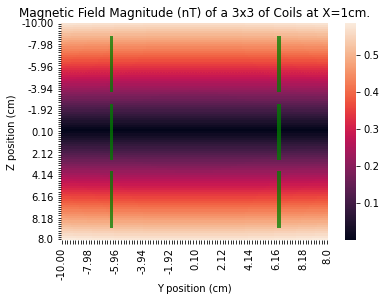

6.25 6.25 25.0 25.0
37.5 6.25 25.0 25.0
68.75 6.25 25.0 25.0
6.25 68.75 25.0 25.0
37.5 68.75 25.0 25.0
68.75 68.75 25.0 25.0


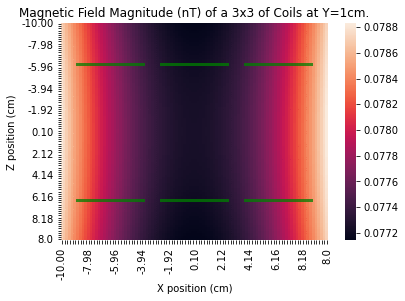

6.25 6.25 25.0 25.0
37.5 6.25 25.0 25.0
68.75 6.25 25.0 25.0
6.25 37.5 25.0 25.0
37.5 37.5 25.0 25.0
68.75 37.5 25.0 25.0
6.25 68.75 25.0 25.0
37.5 68.75 25.0 25.0
68.75 68.75 25.0 25.0


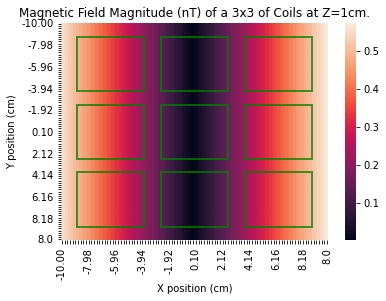

In [105]:
create_field('x',1)
create_field('y',1)
create_field('z',1)

6.25 6.25 25.0 25.0
37.5 6.25 25.0 25.0
68.75 6.25 25.0 25.0
6.25 37.5 25.0 25.0
37.5 37.5 25.0 25.0
68.75 37.5 25.0 25.0
6.25 68.75 25.0 25.0
37.5 68.75 25.0 25.0
68.75 68.75 25.0 25.0


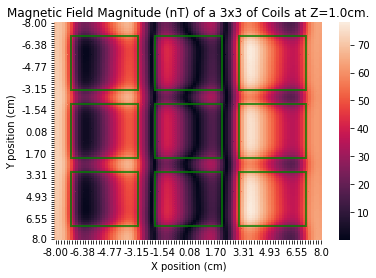

In [24]:
if __name__ == '__main__':
    # define some random constants to plot
    x_axis = np.linspace(-10, 10, num=100)
    y_axis = np.linspace(-10, 10, num=100)
    A1, B1, Z0, I, spacing = 2, 2, 0.0, 1, 1.0
    
    
    Z = 1.0

    GRID = 3
    xx, yy = get_coordinates(A1, B1, spacing, GRID, 0, 0)
    size = max((GRID-1), 1) * A1 * spacing * 2 # 2*2*1*2=8

    grid = np.zeros((100, 100))
    x_axis = np.linspace(-size, size, 100)
    y_axis = np.linspace(-size, size, 100)
    unit = 100 / (2*size) # convert cm grid (2*size x 2*size) to matplotlib unit grid (100x100 plot)
    for i, x in enumerate(x_axis):
        for j, y in enumerate(y_axis):
            # visualize coil placement by plotting distance to closest coil for each (x,y)

            # v = [np.sqrt((x - xx[ii, jj])**2 + (y - yy[ii, jj])**2)
            #     for ii in range(GRID) for jj in range(GRID)]
            # grid[i, j] = min(v)

            # get the magnitude of the field at each x, y

            B = get_gradient(x, y, Z, A1, B1, Z0, I, GRID, spacing)
            grid[i, j] = np.linalg.norm(B, axis=0)

    # plot the grid
    xticks = ['' if i % 10 else f'{x_axis[i]:.2f}' for i in range(len(x_axis))][:-1] + [x_axis[-1]]
    yticks = ['' if i % 10 else f'{y_axis[i]:.2f}' for i in range(len(y_axis))][:-1] + [y_axis[-1]]
    ax = sns.heatmap(grid, xticklabels=xticks, yticklabels=yticks)

    overlay_coils(A1, B1, GRID, spacing, unit, ax)

    plt.title(f'Magnetic Field Magnitude (nT) of a {GRID}x{GRID} of Coils at Z={Z}cm.')
    plt.xlabel('X position (cm)')
    plt.ylabel('Y position (cm)')

    plt.show()